In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [27]:
train = pd.read_csv("train.csv", low_memory="False")
test = pd.read_csv("test.csv", low_memory="False")
full = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
PassengerId = test['PassengerId']



### Some imputing and feature engineering that has to be done outside of the pipeline transformer

In [28]:
train['Sex'] = pd.get_dummies(train['Sex'])
train['Embarked'] = pd.get_dummies(train['Embarked'])
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = np.where(train['FamilySize'] == 1, 0, 1)
imp_cat = SimpleImputer(strategy='most_frequent')
imp_cat.fit_transform(train)

test['Sex'] = pd.get_dummies(test['Sex'])
test['Embarked'] = pd.get_dummies(test['Embarked'])
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = np.where(test['FamilySize'] == 1, 0, 1)
imp_cat = SimpleImputer(strategy='most_frequent')
imp_cat.fit_transform(test)

array([[892, 3, 'Kelly, Mr. James', ..., 0, 1, 0],
       [893, 3, 'Wilkes, Mrs. James (Ellen Needs)', ..., 0, 2, 1],
       [894, 2, 'Myles, Mr. Thomas Francis', ..., 0, 1, 0],
       ...,
       [1307, 3, 'Saether, Mr. Simon Sivertsen', ..., 0, 1, 0],
       [1308, 3, 'Ware, Mr. Frederick', ..., 0, 1, 0],
       [1309, 3, 'Peter, Master. Michael J', ..., 1, 3, 1]], dtype=object)

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,0


In [30]:
y = train.Survived.values
x = train.drop(['Survived','PassengerId','Name', 'Ticket', 'Cabin'], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=17)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), StandardScaler(), LogisticRegression(random_state=17, solver='lbfgs', penalty='l2', max_iter=10000))
pipe_lr.fit(x_train, y_train)
y_pred = pipe_lr.predict(x_test)
print('Test Accuracy: %.3f' % pipe_lr.score(x_test, y_test))

Test Accuracy: 0.771


In [32]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(x_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(x_train[train], y_train[train])
    score = pipe_lr.score(x_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [398 242], Acc: 0.792
Fold:  2, Class dist.: [398 242], Acc: 0.778
Fold:  3, Class dist.: [398 243], Acc: 0.845
Fold:  4, Class dist.: [399 242], Acc: 0.761
Fold:  5, Class dist.: [399 242], Acc: 0.859
Fold:  6, Class dist.: [399 242], Acc: 0.859
Fold:  7, Class dist.: [399 242], Acc: 0.859
Fold:  8, Class dist.: [399 242], Acc: 0.817
Fold:  9, Class dist.: [399 242], Acc: 0.775
Fold: 10, Class dist.: [399 242], Acc: 0.746


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=x_train, y=y_train, cv=10, n_jobs=-1)
print('CV accuracy scores: \n %s' % scores)

print('\n CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: 
 [0.79166667 0.77777778 0.84507042 0.76056338 0.85915493 0.85915493
 0.85915493 0.81690141 0.77464789 0.74647887]

 CV accuracy: 0.809 +/- 0.042


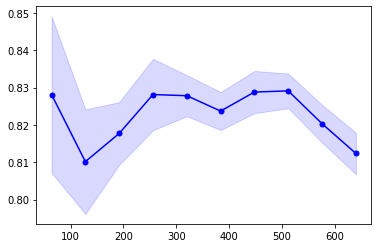

In [34]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores= learning_curve(estimator=pipe_lr, X=x_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

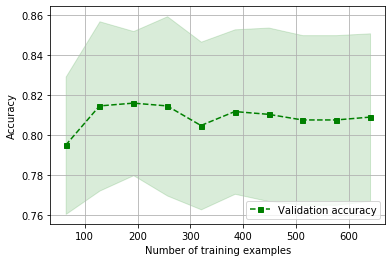

In [35]:
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0, 0.5, 'Accuracy')

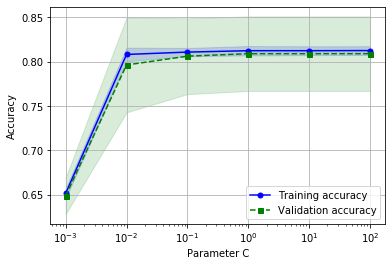

In [39]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=x_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')